# Задание

Дана следующая задача: $(x−μ_0)^⊤A(x−μ_0) \to min$

При ограничении евклидовой нормой: $∥x∥^2_2=∥x∥^2≤1$, что эквивалентно $(\sqrt{\sum_{i=1}^{n}|x_i|^2})^2=\sum_{i=1}^{n}x_i^2=x_1^2+...+x_n^2≤1$

Где: где $x∈R^n$, $A$ - симметричная, положительно определенная матрица, $μ_0= (1, 1, . . . , 1)^⊤∈R^n$.
1) Исследовать задачу на выпуклость.
2) Для каждого значения $n∈\{10, 20, ..., 100\}$ сгенерировать $N=100$ тестовых примеров. В каждом случае найдите глобальный минимум, $x^∗∈R^n$, с помощью CVX. Проверьте, что в точке минимума выполняется условие оптимальности (т.е. вектора градиента к ограничению и антиградиента к целевой функциисонаправлены).
3) Для каждого значения $n∈\{10, 20, ..., 100\}$ и для каждого тестового примера $N_i,\ i$ от 1 до 100 сгенерировать по $p=100$ начальных точек. В зависимости от варианта (v3) реализуйте следующие методы решения задачи для заданной точности $ε=0.01$ (Используйте в качестве точности либо разность между текущим значением функции и оптимальным (из солвера), либо некоторую меру выполнения условий оптимальности):
    * Gradient descent for strongly convex and Lipschitz functions ([Section 3.4.1, Theorem 3.9](https://arxiv.org/pdf/1405.4980#page=50));
    * Gradient descent for smooth functions ([Section 3.2, Theorem 3.7](https://arxiv.org/pdf/1405.4980#page=43));
    
    $\to$ Gradient descent for strongly convex and smooth functions ([Section 3.4.2, Theorem 3.12](https://arxiv.org/pdf/1405.4980#page=52));
    * Conditional gradient descent, aka Frank-Wolfe ([Section 3.3, Theorem 3.8](https://arxiv.org/pdf/1405.4980#page=45));
    * Exact line search ([Section 9.2](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=477));
    * Backtracking line search  ([Section 9.2](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=477)).
4) Объясните принцип работы метода, опишите его преимущества и недостатки.
5) В качестве результата работы метода:
    * Для каждого значения $n∈\{10, 20, ..., 100\}$ подсчитайтесреднее время работы метода и среднее число итераций (усреднение проводится по всем начальным точкам и повсем тестовым примерам);
    * Для одного тестового примера при $n=10$ и нескольких различных начальных точек постройте зависимость точности от числа итераций. Зависит ли скорость сходимости метода от отношения максимального и минимального собственных чисел матрицы A? Сравните полученные результаты с теоретическими верхними оценками (толькодля вариантов 1-4, обратите внимание, что для сравнения с теоретическими верхними оценками необходимо считать точность тем же способом, как это делается в соответствующей оценке).
6) Оформите отчет с последовательным изложением пунктов 1-5 и выводами.

# Настройки/Импорты

Версии важных модулей:
cvxpy==1.4.3

In [36]:
import cvxpy as cp # солвер для задач
import numpy as np # для работы с массивами
from sklearn.datasets import make_spd_matrix # для генерации симметричной положительно определённой матрицы A для поставленной задачи

from tqdm import tqdm # для отслеживания прогресса
from matplotlib import pyplot as plt # для построения графиков/вывода изображений

In [2]:
n = np.arange(10, 101, 10) # возможные значения n (число переменных в задаче ~ размерность пространства) от 10 до 100 включительно
N = 100 # число тестовых примеров для каждого значения n
p = 100 # число начальных точек для каждого примера N
ε = 0.01 # необходимая точность

# 1) Исследование на выпуклость

Определения: 
1) ***Smooth function*** — это функция, которая имеет непрерывные производные до некоторого желаемого порядка в некоторой области.
2) ***Strongly convex function*** — функция, для которой справедливо неравенство: $f″≥m>0$. Такая функция является *строго выпуклой* и растёт не медленнее квадратичной.

Данная функция $(x−μ_0)^⊤A(x−μ_0)$ — квадратичная. По критерию Сильвестра она выпукла тогда и только тогда, когда матрица $A$ — положительно определена, то есть когда все её угловые миноры $\Delta_i$ положительны. Согласно условию задания матрица $A$ уже симметричная и положительно определённая — поэтому функция является выпуклой.

Примеры:
* Если $n=2$, функция будет иметь следующий вид (квадратичный):<br>
    $a_{11}(x_1-μ_1)^2+a_{22}(x_2-μ_2)^2+2a_{12}(x_1-μ_1)(x_2-μ_2) \to min$

    А её ограничение:<br>
    $x_1^2+x_2^2≤1$

    Пусть $A$ — $\begin{bmatrix} 5 & 3 \\ 3 & 5 \end{bmatrix}$, $μ_0= (1, 1)^T$. Тогда график функции (эллипсоид) вместе с ограничением примет следующий вид:<br>
    ![Пример в 2D](./images/example_2d.png)

* Если $n=3$, функция будет иметь следующий вид (квадратичный):<br>
    $a_{11}(x_1-μ_1)^2+a_{22}(x_2-μ_2)^2+a_{33}(x_3-μ_3)^2+2a_{12}(x_1-μ_1)(x_2-μ_2)+2a_{13}(x_1-μ_1)(x_3-μ_3)+2a_{23}(x_2-μ_2)(x_3-μ_3) \to min$

    А её ограничение:<br>
    $x_1^2+x_2^2+x_3^2≤1$

    Пусть $A$ — единичная матрица, то есть на её диагонали стоят единицы, а всё остальное — нули (такая матрица положительно определена), $μ_0= (1, 1, 1)^T$. Тогда часть функции без квадратов занулится и её график (станет сферой, иначе — эллипсоид) вместе с ограничением примет следующий вид:<br>
    ![Пример в 3D](./images/example_3d.png)

# 2) Генерация и решение тестовых примеров с помощью встроенных методов.

**Важно: в CVX по стандарту переменные идут не в виде столбца, а в виде строки. Однако, при желании можно заменить shape=(n) на shape=(n, 1) чтобы всё было как в обычной математике.**

In [7]:
data = {} # словарь под данные для теста

for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    data[dim] = dict.fromkeys(range(N), {}) # подсловарь под тест-кейсы для рассматриваемой размерности dim (получилась тройная вложенность словаря)
    for i in range(N): # идём по числу тест-кейсов
        # решаем задачу с помощью солвера
        A = make_spd_matrix(n_dim=dim) # генерируем случайную симметричную положительно определённую матрицу A
        x = cp.Variable(shape=(dim)) # значения переменных 
        μ = np.ones(shape=(dim)) # смещение центра функции
        objective = cp.Minimize(cp.quad_form(x-μ, A)) # минимизируем квадратичную функцию
        # objective = cp.Minimize((x-μ).T @ A @ (x-μ)) # как должно быть с обычной математикой (не запустить, так как CVX считает такую проблему не выпуклой)
        constraints = [cp.sum_squares(x) <= 1] # накладываемое ограничение — сумма квадратов переменных меньше или равна 1
        problem = cp.Problem(objective, constraints) # создаём объект решаемой задачи
        result = problem.solve(solver=cp.ECOS) # решаем поставленную проблему с помощью solver

        data[dim][i]["A"] = A # запоминаем матрицу A
        data[dim][i]["X opt solver"] = x.value # оптимальное значение X от встроенного солвера
        data[dim][i]["Result solver"] = result # ответ от встроенного солвера

        data[dim][i]["X opt function"] = None # оптимальное значение X от написанной функции
        data[dim][i]["Result function"] = None # ответ от написанной функции

100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


In [9]:
data[10][0] # тест-кейс 0 для для 10 переменных

{'A': array([[ 3.88523565, -1.92350291,  0.18945252,  0.08218569, -1.89324596,
         -2.15379709,  0.486222  ,  0.28015441, -3.15035418, -0.3297395 ],
        [-1.92350291,  1.77091814,  0.11262044, -0.06428775,  1.12673735,
          1.25389767, -0.43409304, -0.25127061,  1.64772897,  0.0849678 ],
        [ 0.18945252,  0.11262044,  0.42057856, -0.11548254, -0.11098198,
         -0.04348646,  0.14242744, -0.00934242, -0.17664352, -0.05067927],
        [ 0.08218569, -0.06428775, -0.11548254,  0.48183918,  0.08992349,
          0.02571535,  0.07629461, -0.07045691, -0.066982  , -0.12519616],
        [-1.89324596,  1.12673735, -0.11098198,  0.08992349,  1.40619562,
          1.14157509, -0.22376344, -0.08900254,  1.66125201,  0.06856734],
        [-2.15379709,  1.25389767, -0.04348646,  0.02571535,  1.14157509,
          2.03873961, -0.398548  , -0.2764925 ,  2.18551622,  0.14581385],
        [ 0.486222  , -0.43409304,  0.14242744,  0.07629461, -0.22376344,
         -0.398548  ,  0.64

# 3) Реализация и тестирование градиентного спуска для строго выпуклых и гладких функций.

**Определения:**
1) Функция $f(x)$ называется ***α-strongly convex*** (строго выпуклой с параметром *α > 0*), если для $∀x ∈ dom(f)$ выполняется: $f(x)-\frac{α}{2}∥x∥^2$ — выпукла. <br>
Или, что аналогично, $(∇f(x) − ∇f(y))^T(x-y)≥α∥x-y∥^2$. Для дважды дифференцируемых функций это означает, что $\lambda_{min}(∇^2f(x))≥α$.
2) Непрерывно дифференцируемая функция $f(x)$ называется ***β-smooth*** (гладкой с параметром *β*), если её градиент $∇f$ — *β-Липшицев*. <br>
То есть если она обладает Липшицевым градиентом с константой *β*: $∥∇f(x) − ∇f(y)∥ ≤ β∥x − y∥$. Для дважды дифференцируемых функций это означает, что $\lambda_{max}(∇^2f(x))≤β$.

Strong convexity (строгая выпуклость) даёт нижнюю оценку кривизны функции значением *α*. Другими словами, все собственные значения Гессиана α-strongly convex function ограничены снизу величиной *α*. <br>
*β-smoothness* ограничивает кривизну функции (изменение градиента) некоторой константой *β*. Это эквивалентно тому, что собственные значения Гессиана меньше *β*. <br>
Объединив свойства *α-strongly convex* и *β-smooth* функций получаем, что собственные значения Гессиана находятся в области $α ≤ ∇^2f(x) ≤ β$.

***Теорема:*** Если $f$ это *β-smooth* и *α-strongly convex function* на $R^n$. Тогда градиентный спуск с шагом $η = \frac{2}{α+β}$ удовлетворяет выражению (скорость сходимости) <br>
$f(x_{t+1}) − f(x^∗) ≤ \frac{β}{2}e^{−\frac{4t}{k+1}}∥x_1-x^*∥^2$, где $k=\frac{β}{α}$.

В рассматриваемой задаче $f(x)=(x−μ_0)^⊤A(x−μ_0) \to min$ градиент функции $f(x)$ есть: <br> 
* $∇f(x) = 2A(x-μ_0)$

Гессиан же есть матрица $2A$. <br>
* $∇^2f(x)=2A$

Параметр α строгой выпуклости считается по формуле:
* $α=2\lambda_{min}(A)$

Параметр β гладкости считается по формуле:
* $β=2\lambda_{max}(A)$.

Идём в сторону, противоположную градиенту, так как он направлен в сторону наискорейшего роста, а нам нужно обратное — минимизировать функцию.

In [81]:
def func(x: np.array, A: np.array, μ: np.array) -> np.float32:
    """
    Функция из задачи (значение x в виде столбца, а не строки, как было во встроенном методе!).\n
    Parameters:
        * x: текущие значения x
        * A: матрица A
        * μ: смещение центра функции\n
    Returns:
        * np.float32: значение функции в точке x
    """
    return (x-μ).T @ A @ (x-μ) # значение функции задачи (было бы (x-μ) @ A @ (x-μ).reshape((dim,1)), если бы x шёл как строка, а не столбец)

In [82]:
def func_der(x: np.array, A: np.array, μ: np.array) -> np.array:
    """
    Производная функция из задачи (значение x в виде столбца, а не строки, как было во встроенном методе!).\n
    Parameters:
        * x: текущие значения x
        * A: матрица A
        * μ: смещение центра функции\n
    Returns:
        * np.float32: значение функции в точке x
    """
    return 2 * A @ (x - μ) # значение производной функции задачи
    # return 2 * A @ x # значение производной функции задачи

In [83]:
def constraints(x) -> bool:
    """
    Функция для проверка решения на допустимость.\n
    Parameters:
        * x: текущие значения x\n
    Returns:
        * bool: True — если решение допустимо, иначе — False
    """
    return np.linalg.norm(x, ord=2) ** 2 <= 1 # квадрат евклидовой нормы решения должен быть ≤ 1

In [84]:
μ = np.ones(shape=(2)) # смещение центра функции
X = [] # список под значения переменных x
Y = [] # список под значения целевой функции

In [85]:
dim = 2

# ограничение задачи — квадрат евклидовой нормы вектора x ≤ 1
x = np.random.randint(low=0, high=100, size=(dim, 1)) # генерируем случайные числа размера числа переменных (изначально они могут нарушать ограничения)
x = x/np.linalg.norm(x, ord=2) # делим значение сгенерированного вектора на его евклидову норму, чтобы новая норма была точно ≤ 1 (на самом деле она будет лишь слегка меньше 1, но такая точка уже не нарушает ограничение задачи)
A = np.array([[5,3], [3,5]]) # симметричная положительно определённая матрица
μ = np.ones(shape=(dim, 1)) # смещение центра функции

# считаем шаг для функции
eigenvalues = np.linalg.eigvals(A) # собственные значения матрицы A
α = 2 * eigenvalues.min() # параметр выпуклости функции, в данном случае равен 2 * минимальное собственное значение матрицы A
β = 2 * eigenvalues.max() # параметр гладкости функции, в данном случае равен 2 * максимальное собственное значение матрицы A
η = 2 / (α + β) # значение шага

y = func(x, A, μ)[0] # считаем начальное значение функции
X.append(x) # запоминаем начальную точку (всегда будет идти под индексом 0)
Y.append(y) # запоминаем начальное решение

In [86]:
while constraints(x):
    x = x - η * func_der(x, A, μ) # обновляем значение x
    y = func(x, A, μ)[0] # считаем начальное значение функции
    X.append(x) # запоминаем начальную точку (всегда будет идти под индексом 0)
    Y.append(y) # запоминаем начальное решение

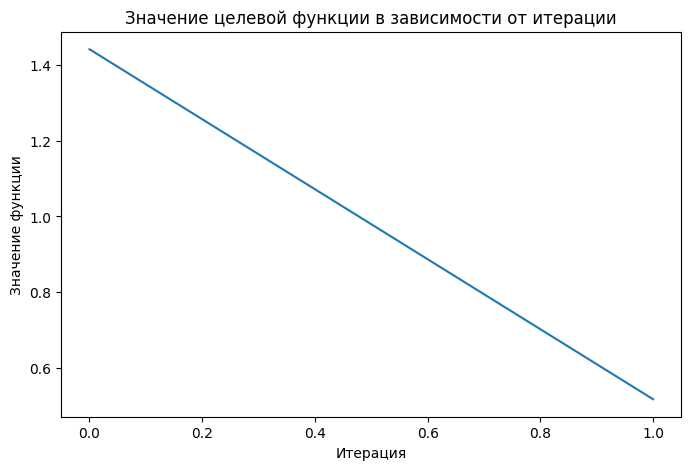

In [87]:
plt.figure(figsize=(8,5)) # задание размера фигуры
plt.plot(range(len(X)), Y) # строим график
plt.title("Значение целевой функции в зависимости от итерации") # название фигур
plt.xlabel("Итерация") # подпись по оси x
plt.ylabel("Значение функции") # подпись по оси y
plt.show() # показ фигуры

In [88]:
def gradient_descent(func, constr, x_init, ε) -> list:
    """
    Метод градиентного спуска для подсчёта оптимума функции.\n
    Parameters:
        * func: функция, что нужно минимизировать
        * constr: функция-ограничение, проверяющая значение x
        * x_init: изначальное значение x
        * ε: необходимая точность ответа\n
    Returns:
        * list: оптимальное значение функции и x
    """
    

In [6]:
A = np.array([[5,3], [3,5]]) # генерируем случайную симметричную положительно определённую матрицу A
x = cp.Variable(shape=(2)) # значения переменных 
μ = np.ones(shape=(2)) # смещение центра функции
objective = cp.Minimize(cp.quad_form(x-μ, A)) # минимизируем квадратичную функцию
# objective = cp.Minimize((x-μ).T @ A @ (x-μ)) # как должно быть с обычной математикой (не запустить, так как CVX считает такую проблему не выпуклой)
constraints = [cp.sum_squares(x) <= 1] # накладываемое ограничение — сумма квадратов переменных меньше или равна 1
problem = cp.Problem(objective, constraints) # создаём объект решаемой задачи
result = problem.solve(solver=cp.ECOS) # решаем поставленную проблему с помощью solver

print(result, x.value)

1.3725829956461402 [0.70710678 0.70710678]


# 4) Принцип работы метода

1) Генерируем случайное начальное решение *x*;
2) 

# 5) Результаты работы метода